In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, KFold
import itertools

import warnings
warnings.filterwarnings("ignore")

In [2]:
btc_df = pd.read_csv(r'sentiment_btc.csv', index_col=0)
eth_df = pd.read_csv(r'sentiment_eth.csv', index_col=0)
price_df = pd.read_csv(r'Prices.csv', index_col=0)

## Pre-Processing

In [3]:
price_df = price_df['2020-01-01 00:00:00':'2020-05-30 00:00:00']
price_df.index = pd.to_datetime(price_df.index, utc=True)
price_df = price_df.sort_values(by='Date')
price_df.index = price_df.index.date
price_df.index.name = 'Date'

In [4]:
def PreProc(df, price_df=price_df):
    df['Date'] = pd.to_datetime(df['Date'], utc=False)
    df = df.set_index('Date')

    df = df.drop(columns='Tweet', axis=0)
    df = df.sort_values('Date')

    merge_df = df
    merge_df.index = merge_df.index.date
    merge_df.index.name = 'Date'

    merge_df['Impact'] = 2*merge_df['Retweet']*merge_df['classes'] + merge_df['Likes']*merge_df['classes']
    merge_df = pd.get_dummies(merge_df, columns=['classes'])

    merge_df = merge_df.groupby('Date')[['Impact', 'classes_-1', 'classes_1']].sum()
    merge_df = pd.merge(merge_df, price_df, on='Date')

    return merge_df

### BTC

In [5]:
btc_merge = PreProc(btc_df)
btc_merge.head()

,Impact,classes_-1,classes_1,+1D BTC,+1D ETH,BTC_close,ETH_close
Date,,,,,,,
2020-01-01,12907,10,38,0,0,7200.174393,130.802008
2020-01-02,12894,12,33,1,1,6985.470001,127.410182
2020-01-03,26914,13,52,1,1,7344.884183,134.171712
2020-01-04,9551,11,24,1,1,7410.656566,135.069371
2020-01-05,18484,16,26,1,1,7411.317327,136.276777


In [6]:
btc_merge = btc_merge.iloc[:, :4]

### ETH

In [7]:
eth_merge = PreProc(eth_df)
eth_merge.head()

,Impact,classes_-1,classes_1,+1D BTC,+1D ETH,BTC_close,ETH_close
Date,,,,,,,
2020-01-01,3861,6,13,0,0,7200.174393,130.802008
2020-01-02,7842,5,21,1,1,6985.470001,127.410182
2020-01-03,1949,12,15,1,1,7344.884183,134.171712
2020-01-04,5116,1,14,1,1,7410.656566,135.069371
2020-01-05,6867,6,11,1,1,7411.317327,136.276777


In [8]:
eth_merge = eth_merge.iloc[:, [0, 1, 2, 4]]

## Train-Test-Split

In [30]:
date1 = pd.to_datetime('2020-04-30').date()
date2 = pd.to_datetime('2020-05-01').date()

In [41]:
train = btc_merge[:date1]
test = btc_merge[date2:]

In [42]:
#train = eth_merge[:date1]
#test = eth_merge[date2:]

In [43]:
x_train = train.iloc[:, :3]
y_train = train.iloc[:, 3]

x_test = test.iloc[:, :3]
y_test = test.iloc[:, 3]

## Model

### Prediksi

### Klasifikasi

In [44]:
model = xgb.XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [45]:
scores = cross_val_score(model, x_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.51


In [46]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(model, x_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.49


In [47]:
def plot_confusion_matrix(cm, classes, 
                            normalize=False, 
                            title='Confusion matrix', 
                            cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [48]:
def Evaluation(model, X_train, y_train, X_test, y_test):
    pred = model.predict(X_train)
    yhat = model.predict(X_test)
    print(classification_report(y_test, yhat))
    print("_______________________________________________")

    train_score = accuracy_score(y_train, pred) * 100
    test_score = accuracy_score(y_test, yhat) * 100

    print(f"Train accuracy Score: {train_score}%")
    print(f"Test accuracy Score: {test_score}%")

    cnf = confusion_matrix(y_test, yhat, labels=[1,0])
    plt.figure()
    plot_confusion_matrix(cnf,classes=['output =1', 'output=0'],normalize = False, title='Confusion matrix')

    return  train_score, test_score, cnf

              precision    recall  f1-score   support

           0       0.36      0.36      0.36        11
           1       0.61      0.61      0.61        18

    accuracy                           0.52        29
   macro avg       0.49      0.49      0.49        29
weighted avg       0.52      0.52      0.52        29

_______________________________________________
Train accuracy Score: 100.0%
Test accuracy Score: 51.724137931034484%
Confusion matrix, without normalization
[[11  7]
 [ 7  4]]


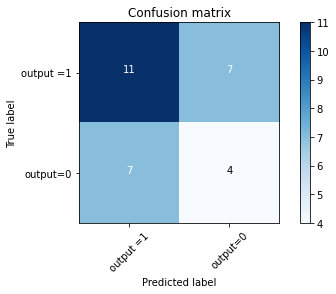

In [49]:
x, y, cnf = Evaluation(model, x_train, y_train, x_test, y_test)

results_df = pd.DataFrame(data=[["XGBoost", x, y]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])